#### Imports libraries and display settings

In [27]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import time
from scipy.stats import pearsonr
import math
import matplotlib.backends.backend_pdf
from scipy.stats import zscore
import pickle
from collections import Counter
from scipy.stats import ttest_ind
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Small math functions

In [12]:
## Split time-series data "a" into "n" segments (i.e. downsampling to "n" samples)
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

## Calculate parametric Pearson correlation p-value ##
def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

## Calculate absolute distance between 2 values ##
def distance(x, y):
    if x >= y:
        result = x - y
    else:
        result = y - x
    return result

## Find most common-occurring element in list ##
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

#### Data manipulation functions

In [13]:
def calculate_posteriors(group_df, size, protocol, dtype):
    if 'reversed outcomes' in list(sesh_df.index.names):
        outcome_label = 'reversed outcomes'
    else:
        outcome_label = 'Final Outcome'
        
    posteriors = {}
    for block in range(1000):        
        if block+size > group_df.shape[0]:
            break
        else:
            block_df = group_df[block:block+size]
    
            posteriors[block] = {}
            posteriors[block]['reward prob'] = {}
            posteriors[block]['stimulus ratios'] = {}
            posteriors[block]['response rate'] = {}
            posteriors[block]['rare prob'] = {}
            posteriors[block]['nresp'] = {}
            
            if 'det' not in protocol:
                Go_df = block_df[(block_df.index.get_level_values(outcome_label).str.contains('hit')) | (block_df.index.get_level_values(outcome_label).str.contains('miss'))]
                Go_ID_list = list(Go_df.index.get_level_values('Stimulus'))
                Go_ID = most_frequent(Go_ID_list)
                NoGo_ID = float(1) if Go_ID == float(2) else float(2)
                Go = block_df[block_df.index.get_level_values('Stimulus') == Go_ID]
                NoGo = block_df[block_df.index.get_level_values('Stimulus') == NoGo_ID]
            else:
                Go = block_df[block_df.index.get_level_values('Stimulus') != float(3)]
                NoGo = block_df[block_df.index.get_level_values('Stimulus') == float(3)]
                
            rew_probs = {}
            response_probs = {}
            responses = {}
            for m, modality in zip(['G','N'],[Go, NoGo]):
                nFA = modality[modality.index.get_level_values(outcome_label).str.contains('FA')].shape[0]
                nHIT = modality[modality.index.get_level_values(outcome_label).str.contains('hit')].shape[0]
                ntype = modality.shape[0]
                nrew = modality[modality.index.get_level_values('Water') == float(1)].shape[0]
                rew_prob = nrew/(nFA+nHIT) if nFA+nHIT > 2 else np.nan
                rew_probs[m] = rew_prob
                response_probs[m]  = (nFA+nHIT)/ntype
                responses[m] = nFA+nHIT
            rare = Go[(Go.index.get_level_values('Water') == float(0)) & (Go.index.get_level_values(outcome_label).str.contains('hit'))].shape[0] + NoGo[(NoGo.index.get_level_values('Water') == float(1)) & (NoGo.index.get_level_values(outcome_label).str.contains('FA'))].shape[0]
            frequent = Go[(Go.index.get_level_values('Water') == float(1)) & (Go.index.get_level_values(outcome_label).str.contains('hit'))].shape[0] + NoGo[(NoGo.index.get_level_values('Water') == float(0)) & (NoGo.index.get_level_values(outcome_label).str.contains('FA'))].shape[0]
            if (rare > 2) & (frequent > 2):
                posteriors[block]['rare prob'] = rare/frequent
            else:
                posteriors[block]['rare prob'] = np.nan
            posteriors[block]['reward prob'] = rew_probs
            posteriors[block]['response rate'] = response_probs
            posteriors[block]['nresp'] = responses
           
            ntrials = block_df.shape[0]
            posteriors[block]['stimulus ratios'] = {'G':Go.shape[0]/ntrials,
                                                    'N':NoGo.shape[0]/ntrials}
    
    return posteriors

In [19]:
def reverse_outcomes(sesh_df):
    outcome_list = []
    for index, rows in sesh_df.iterrows():
        out = index[-1]
        if 'hit' in out:
            outcome_list.append(out.split(' hit')[0]+' FA')
        elif 'FA' in out:
            outcome_list.append(out.split(' FA')[0]+' hit')                     
        elif 'miss' in out:
            outcome_list.append(out.split(' miss')[0]+' CR')  
        elif 'CR' in out:
            outcome_list.append(out.split(' CR')[0]+' miss')
        else:
            print(out, 'unexpected outcome label')
    
    return outcome_list

In [24]:
def calculate_session_rates(posteriors_df, sesh_df, sesh, protocol, dtype, mouse):
    prop_rare = posteriors_df['reward prob']['N'] / posteriors_df['reward prob']['G']
    hit_rate = posteriors_df['response rate']['G']
    FA_rate = posteriors_df['response rate']['N']
    correct = sesh_df[(sesh_df['Final Outcome'].str.contains('hit')) | (sesh_df['Final Outcome'].str.contains('CR'))].shape[0]
    CP_rate = correct/sesh_df.shape[0]
    
    FA = sesh_df[sesh_df['Final Outcome'].str.contains('FA')]
    if FA.shape[0] > 0:
        FA_latency = (FA['Response latency']).mean()
        FA_licks = (FA['Anticipatory licks']).mean() if FA['Anticipatory licks'].shape[0] > 0 else 0
        if dtype == 'deltaF':
            FA_licks_rew = (FA['Reward licks']).mean() if FA['Reward licks'].shape[0] > 0 else 0
        else:
            FA_licks_rew = (FA[' Reward licks']).mean() if FA[' Reward licks'].shape[0] > 0 else 0      
    else:
        FA_latency = np.nan
        FA_licks = 0
        FA_licks_rew = np.nan

    hit = sesh_df[sesh_df['Final Outcome'].str.contains('hit')]
    if hit.shape[0] > 0:
        hit_latency = (hit['Response latency']).mean()
        hit_licks = (hit['Anticipatory licks']).mean() if hit['Anticipatory licks'].shape[0] > 0 else 0
        if dtype == 'deltaF':
            hit_licks_rew = (hit['Reward licks']).mean() if hit['Reward licks'].shape[0] > 0 else 0
        else:
            hit_licks_rew = (hit[' Reward licks']).mean() if hit[' Reward licks'].shape[0] > 0 else 0      
    else:
        hit_latency = np.nan
        hit_licks = 0
        hit_licks_rew = np.nan
        
    norm_licks = hit_licks/FA_licks if FA_licks > 0 else np.nan
    final_df = pd.DataFrame([CP_rate, hit_rate, FA_rate, prop_rare, norm_licks, hit_licks, FA_licks, hit_licks_rew, FA_licks_rew, hit_latency, FA_latency, protocol], 
                            index=['CP rate','Hit rate','FA rate','Rare outcome proportion','Hit/FA licks', 'Hit ant', 'FA ant', 'Hit rew','FA rew', 'Hit latency','FA latency', 'Protocol'], 
                            columns=[mouse+'_'+sesh]).T
    final_df = final_df.reset_index().set_index(['index','Protocol'])

    return final_df

#### Plotting functions

In [15]:
def plot_and_extract_correlated_ROIs(r_thresh, event_thresh, time_thresh):
    
    """Plots correlated ROI pairs from "cohort_correlation" dict (individual mouse .npy files saved elsewhere in a previous script), and saves plots as a pdf. 
    There is also the option of re-defining new correlation criteria, and saves these correlation metrics as a .npy file.
    
    Parameters
        r_thresh: minimum Pearson r correlation coeffcient required for a pair of ROIs to be considered correlated
        event_thresh: minimum proportion of shared calcium events required for a pair of ROIs to be considered correlated
        time_thresh: maximum number of frames between calciume events to be considered a "shared events"
        
    Returns:
        Plots correlated ROIs session traces if the pdf for the given correlation criteria doesn't already exist.
    """
    
    ## Pdf file naming/directory setup ##
    fname = 'correlated_ROIs_'+str(r_thresh)+'rthresh_'+str(event_thresh)+'eventthresh' #pdf filename based on correlation criteria
    
    if fname+'.pdf' in os.listdir(data_directory):
        print(fname+'.pdf already exists') #no function performed if pdf already exists for the current criteria
    else:
        pdf = matplotlib.backends.backend_pdf.PdfPages(data_directory+'\\'+fname+'.pdf') #open up a new pdf with the new filename
        
        ## Loop through nested structure of input dictionaries (mouse --> session --> ROI) ##
        correlated_ROIs = {} #final dictionary to add correlation metrics to (with new correlation criteria considered)
        for mouse, mouse_dict in cohort_correlations.items():
            correlated_ROIs[mouse] = {}
            if 'cross-pairs' in mouse_dict.keys(): #look specifically at correlated pairs of ROIs across channels (as determined by previous script)
                for session, session_dict in mouse_dict['cross-pairs'].items():
                    session_split = session.split('_') #session name should be in the format "protocol_date_FOV"
                    FPS = cohort_params[mouse][session_split[0]][session_split[1]][session_split[2]]['FPS'] #get image acquisition framerate from "cohort_params" dict
                    
                    ## For each ROI, extract the deltaF/events ##
                    for ROI, ROI_dict in session_dict.items():
                        mouse_df = cohort_deltaF[mouse] #mouse deltaF (i.e. all ROIs/sessions) of the current ROI
                        ROI_df = mouse_df[mouse_df.index.get_level_values('Unique_ROI') == ROI] #deltaF of the current ROI
                        trials = ROI_df.index.get_level_values('Trial') #trial numbers of the current ROI
                        ROI_df = (ROI_df - ROI_df.min().min()) / (ROI_df.max().max() - ROI_df.min().min()) #normalized deltaF of each trial for the current ROI
                        ROI_flat = ROI_df.to_numpy().flatten() #concatenate all trials of deltaF and flatten to 1-d array
                        mouse_events = cohort_events[mouse] #mouse events (i.e. all ROIs/sessions) of the current ROI
                        ROI_events = mouse_events[mouse_events['Unique_ROI'] == ROI] #events of the current ROI
                        
                        ## Find peak times of all events for current ROI ##
                        ROI_peak_times = []
                        for index, rows in ROI_events.iterrows():
                            trial_idx = np.where(np.asarray(trials) == rows.Trial)[0][0] #find deltaF index of the trial corresponding to the current event in the loop
                            peak_time = (trial_idx*ROI_df.shape[1]) + (rows['peak_time']*FPS) #(trial number*nframes per trial) + (peak time for current trial*framerate) to determine peak frame number for session trace
                            ROI_peak_times.append(peak_time) if peak_time < ROI_flat.shape[0] else None 
                        ROI_peaks = [ROI_flat[math.ceil(x)] for x in ROI_peak_times] #use peak times to get peak deltaF values from "ROI_flat"

                        ROI_color = 'green' if 'Green' in ROI else 'red'
                        ROI_label = ('_').join(ROI.split('_')[-2:])
                        
                        ## Extract deltaF/events and find peak times of all events for other ROIs in the same FOV (i.e. partner ROIs) ##
                        for partner, r in ROI_dict.items(): #ROI_dict contains every ROI (i.e. partner) that was correlated with the current ROI (from previous script)
                            if r > r_thresh: #Pearson r threshold
                                partner_df = mouse_df[mouse_df.index.get_level_values('Unique_ROI') == partner]
                                partner_df = (partner_df - partner_df.min().min()) / (partner_df.max().max() - partner_df.min().min())
                                partner_flat = partner_df.to_numpy().flatten()
                                partner_flat = partner_flat-0.75 #subtract 0.75 from normalized deltaF of partner ROI for plotting purposes (i.e. to view stacked on top of each other)

                                partner_events = mouse_events[mouse_events['Unique_ROI'] == partner]
                                partner_peak_times = []
                                for index, rows in partner_events.iterrows():
                                    trial_idx = np.where(np.asarray(trials) == rows.Trial)[0][0]
                                    peak_time = (trial_idx*partner_df.shape[1]) + (rows['peak_time']*FPS)
                                    partner_peak_times.append(peak_time) if peak_time < partner_flat.shape[0] else None
                                partner_peaks = [partner_flat[math.ceil(x)] for x in partner_peak_times]

                                partner_color = 'green' if 'Green' in partner else 'red'
                                partner_label = ('_').join(partner.split('_')[-2:])
                                
                                ## Find shared events between current ROI and current partner ROI ##
                                matched_event_times = []
                                matched_event_peaks = []
                                for ROI_time, ROI_peak in zip(ROI_peak_times, ROI_peaks):
                                    for partner_time in partner_peak_times:
                                        if distance(ROI_time, partner_time) <= time_thresh: #if difference in event peak time is <= the max threshold
                                            matched_event_times.append(ROI_time)
                                            matched_event_peaks.append(ROI_peak+0.1) #want to plot an asterisk 0.1 units above the actual peak of the trace
                                
                                ## Calculate shared event ratio, and plot ROI-pair if it is above the threshold ##
                                event_ratio = len(matched_event_times) / len(ROI_peak_times)
                                if event_ratio > event_thresh:
                                    
                                    ## Store Pearson r and ratio of shared events in dictionary ##
                                    if ROI not in correlated_ROIs[mouse].keys():
                                        correlated_ROIs[mouse][ROI] = {}
                                        correlated_ROIs[mouse][ROI][partner] = {'r':r, 'event_ratio':event_ratio}
                                    else:
                                        correlated_ROIs[mouse][ROI][partner] = {'r':r, 'event_ratio':event_ratio}
                                    
                                    ## Plotting parameters ##
                                    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,4))
                                    fig.suptitle(mouse+'_'+session+' \n '+ROI_label, fontsize=25, y=0.98)
                                    ax.plot(partner_flat, color=partner_color, alpha=0.3)
                                    ax.plot(ROI_flat, color=ROI_color,alpha=0.3)

                                    ax.scatter(y=ROI_peaks, x=ROI_peak_times, color=ROI_color, marker='*', s=15)
                                    ax.scatter(y=partner_peaks, x=partner_peak_times, color=partner_color, marker='*', s=15)
                                    ax.scatter(y=matched_event_peaks, x=matched_event_times, color='orange', marker='*', s=25)

                                    ax.set_title(partner_label, fontsize=15)  
                                    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        np.save(data_directory+'\\'+fname+'.npy', correlated_ROIs)
        pdf.close()

In [119]:
def plot_ROI_by_ROI_traces(cohort_epochs, protocols, channels, trialtypes, colors, specific_ROIs, epoch, pre_window, post_window):
    df = pd.concat(cohort_epochs['deltaF']['all'])
    for protocol in protocols:
        protocol_df = df[df.index.get_level_values('Protocol') == protocol]
        for channel in channels:
            channel_df = protocol_df[protocol_df.index.get_level_values('Channel') == channel]
            ROI_groups = channel_df.groupby(channel_df.index.get_level_values('Unique_ROI'))
            if (specific_ROIs == None) | (len(specific_ROIs) == 0):
                roi_list = channel_df.index.get_level_values('Unique_ROI').unique()
            else:
                roi_list = specific_ROIs

            for roi in roi_list:
                ROI_df= ROI_groups.get_group(roi)
                fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharey=True)      
                for col, (ttype, color) in enumerate(zip(['rewarded hit','rewarded FA','unrewarded hit'],['navy','cyan','magenta'])):
                    ttype_df = ROI_df[(ROI_df.index.get_level_values('Final Outcome') == 'Tactile '+ttype) | (ROI_df.index.get_level_values('Final Outcome') == 'Auditory '+ttype)]
                    inferred = []
                    for index, rows in ttype_df.iterrows():
                        fps = 30.3 if len(rows.dropna()) == 364 else 30.54
                        if index[8] == '-':
                            water = 4.5
                            ITI = 8
                        else:
                            if index[13] == '-':
                                water = int(index[8])/1000 + 1
                            else:
                                water = int(index[13])/1000
                            if index[14] == '-':
                                ITI = 8
                            else:
                                ITI = int(index[14])/1000
                        if epoch == 'trial_onset':
                            inferred.append(rows.iloc[math.floor(0*fps):math.floor(0*fps)+post_window].to_frame().reset_index().iloc[:,1:].T)#
                        else:
                            if epoch == 'reward':
                                onset = water
                            elif epoch == 'response':
                                onset = water-1
                            elif epoch == 'stimulus':
                                onset = 3
                            elif epoch == 'trial_onset':
                                onset = 0
                            elif epoch == 'delayed_reward':
                                onset = water+1
                            elif epoch == 'ITI':
                                onset = ITI
                            inferred.append(rows.iloc[math.floor(onset*fps)-pre_window:math.floor(onset*fps)+post_window].to_frame().reset_index().iloc[:,1:].T)
                    if len(inferred) > 0 :
                        inferred_df = pd.concat(inferred)
                        ax[col].plot(inferred_df.mean(), color=color, linewidth=3)
                        for trial, rows in inferred_df.iterrows():
                            if rows.mean() != float(-1):
                                ax[col].plot(rows, color='black', linewidth=1, alpha=0.5)
                        ax[col].set_title(ttype)
                        nsamples = post_window if epoch == 'trial_onset' else pre_window+post_window
                        nticks = int(((nsamples)/30)+1)
                        start_tick = 0 if epoch == 'trial_onset' else -int(pre_window/30)
                        end_tick = int(post_window/30)
                        ax[col].set_xticks(np.linspace(0,nsamples,nticks))
                        ax[col].set_xticklabels([str(int(x)) for x in np.linspace(start_tick,end_tick,nticks)])
                plt.suptitle((' ').join([roi,epoch]))
    #             fig.savefig(roi+'_EXAMPLE_traces.svg')

#### Statistical functions ####

In [46]:
def t_test_pandas(df, comparison_list, metric=None):
    test_df = {}
    if 'Channel' in df.index.names:
        for channel in df.index.get_level_values('Channel').unique():
            channel_df = df[df.index.get_level_values('Channel') == channel]

            channel_results = {}
            for protocol in channel_df.index.get_level_values('Protocol').unique():
                protocol_df = channel_df[channel_df.index.get_level_values('Protocol') == protocol]
                metric_df = protocol_df if metric == None else protocol_df[metric]

                protocol_results = []
                for c in comparison_list:
                    label = (' vs. ').join([c[0], c[1]])
                    hit = list(metric_df[c[0]].dropna())
                    FA = list(metric_df[c[1]].dropna())
                    results = ttest_ind(hit, FA)
                    t_stat = results[0]
                    p_value = results[1]

                    results_df = pd.DataFrame([t_stat, p_value, len(hit), len(FA)], index=['t-stat','p-value','nHit','nFA'], columns=[label]).T
                    protocol_results.append(results_df)
                protocol_results = pd.concat(protocol_results)
                channel_results[protocol] = protocol_results
            test_df[channel] = pd.concat(channel_results)


    else:
        channel = 'Behavior'
        channel_df = df

        channel_results = {}
        for protocol in channel_df.index.get_level_values('Protocol').unique():
            protocol_df = channel_df[channel_df.index.get_level_values('Protocol') == protocol]
            metric_df = protocol_df if metric == None else protocol_df[metric]

            protocol_results = []
            for c in comparison_list:
                label = (' vs. ').join([c[0], c[1]])
                hit = list(metric_df[c[0]].dropna())
                FA = list(metric_df[c[1]].dropna())
                results = ttest_ind(hit, FA)
                t_stat = results[0]
                p_value = results[1]

                results_df = pd.DataFrame([t_stat, p_value, len(hit), len(FA)], index=['t-stat','p-value','nHit','nFA'], columns=[label]).T
                protocol_results.append(results_df)
            protocol_results = pd.concat(protocol_results)
            channel_results[protocol] = protocol_results
        test_df[channel] = pd.concat(channel_results)    
    test_df = pd.concat(test_df)
    test_df.index.names = ['Channel','Protocol','Comparison']
    test_df = test_df.sort_values(['Comparison','Protocol'])
    test_df = test_df[test_df['p-value'] < 0.05]   
    
    return test_df

## Upload calcium and pupil data that has been filtered/processed and split into epochs
**Data format requirements**
- All datafiles should be python dictionaries **.npy** files
- Dictionaries should be nested dictionaries with the keys structured as **epoch (key)** --> **mouse ID (key)** --> **multiindex pandas (data)**

**What should the "epochs" be**
- Different time window segments of the calcium or pupil time-series defined in the preceding notebook

**What should be in the pandas dataframes**
- DeltaF time-series, normalized pupil dilation time-series, detected calcium events with metrics of interest
- Index contains other experimental data such as protocol, date, recording channel, ROI ID, trial number, lick metrics, reward delivery timing, time-out punishment duration

In [16]:
data_directory = r'C:\Users\61407\Desktop\Current analysis\Project 3'#directory where all of the data is stored

cohort_epochs = {}
## Loop through every sub-directory in the data directory to find different datatypes (defined by the iterator "dtype") ##
for dtype in ['events','deltaF','pupil']:
    cohort_dtype = {}
    for root, dirs, files in os.walk(data_directory):
        for f in files:
            if (dtype+'_epochs' in f) & ('Old version' not in root):
                ID = root.split('\\')[-1]
                ID_dtype = np.load(root+'\\'+f, allow_pickle=True).item()

                for epoch, epoch_df in ID_dtype.items():
                    if dtype not in cohort_epochs.keys():
                        cohort_epochs[dtype] = {}
                        
                        if epoch not in cohort_epochs[dtype].keys():
                            cohort_epochs[dtype][epoch] = {}
                            cohort_epochs[dtype][epoch][ID] = epoch_df
                        else:
                            cohort_epochs[dtype][epoch][ID] = epoch_df
                    else:
                        if epoch not in cohort_epochs[dtype].keys():
                            cohort_epochs[dtype][epoch] = {}
                            cohort_epochs[dtype][epoch][ID] = epoch_df
                        else:
                            cohort_epochs[dtype][epoch][ID] = epoch_df

mouse_IDs = cohort_epochs['deltaF']['all'].keys()                         
nmice = len(mouse_IDs) #number of mice in the directory for later plotting purposes
random_colors = cm.rainbow(np.linspace(0,1,nmice)) #get array of random colors (nmice = number of different colors)    

ID_colors = {}
for i, (mouse) in enumerate(mouse_IDs):
    ID_colors[mouse] = random_colors[i]

## Upload ROI pairwise correlation data and Suite2p parameters ##
**Data format requirements**
- Correlation data should be in **"correlations"** of the **processed_calcium.npy** dictionary with the nested structure: **ID** --> **"cross-pairs"** --> **Session** --> **ROI ID** --> **Partner ID** --> **correlation coefficient**
- Also uploads Suite2p parameters dictionary with the nested structure: **ID** --> **Protocol** --> **Date** --> **FOV** --> **Suite2p params file dict**


In [49]:
cohort_correlations = {}
cohort_params = {}
for root, dirs, files in os.walk(data_directory):
    for f in files:
        if ('processed_calcium.npy' in f) & ('Old version' not in root):
            ID = root.split('\\')[-1]
            ID_calcium = np.load(root+'\\'+f, allow_pickle=True).item()
            ID_correlations = ID_calcium['correlations']
            cohort_correlations[ID] = ID_correlations
        if ('params.npy' in f) & ('Old version' not in root):
            ID = root.split('\\')[-1]
            ID_params = np.load(root+'\\'+f, allow_pickle=True).item()
            cohort_params[ID] = ID_params

## Extract behavioural performance from pupil and calcium recording sessions ##
 - Stores trial-by-trial and session-by-session behavioral data in the "extracted_behavior" dictionary, separately for calcium and pupil sessions (i.e. 4 dataframes)

In [29]:
extracted_behavior = {}
for dtype, dtype_dict in cohort_epochs.items():
    if dtype != 'events': #only use deltaF and pupil data because events data does not contain behavioral trials with no events
        extracted_behavior[dtype] = {}
        single_trial_behavior = []
        sesh_by_sesh_behavior = []
        epoch_dict = dtype_dict['all'] #only use one epoch instead of looping through epoch and repeating the same process
        for ID, ID_df in epoch_dict.items():
            ID_df = ID_df.dropna(how='all') #drops all trials where every sample is a nan value
            if ID_df.shape[0] == 0: #drops sessions where there are 0 trials
                None
            else:
                ## Only use data from one ROI/channel per session (i.e. don't need to duplicate the same behavioral trial) ##
                for sesh in ID_df.index.get_level_values('Unique session').unique():
                    sesh_df = ID_df[ID_df.index.get_level_values('Unique session') == sesh]
                    if dtype == 'pupil':
                        first_channel = sesh_df.index.get_level_values('Channel')[0]
                        sesh_df = sesh_df[sesh_df.index.get_level_values('Channel') == first_channel]
                    else:
                        first_ROI = sesh_df.index.get_level_values('Unique_ROI')[0]
                        sesh_df = sesh_df[sesh_df.index.get_level_values('Unique_ROI') == first_ROI]
                        
                    ## Only use data from sessions where there is more than 1 trial type and 30 trials ##
                    if (len(sesh_df.index.get_level_values('Trial type').unique()) > 1) & (sesh_df.shape[0] >= 30):
                        protocol = sesh_df.index.get_level_values('Protocol')[0]
                        posteriors_df = pd.DataFrame(calculate_posteriors(sesh_df, sesh_df.shape[0], protocol, dtype)[0]) #get post-hoc stimulus/response/reward rates
                        
                        ## These are probably sessions where the trialtype labels were reversed (i.e. Go=NoGo, hit=FA, etc...) ##
                        if (posteriors_df['reward prob']['G'] - posteriors_df['reward prob']['N'] < -0.2) | (posteriors_df['rare prob']['G'] > 1.2):
                                    
                            ## Reverse outcomes and run "calculate_posteriors" function again ##
                            reversed_outcomes = reverse_outcomes(sesh_df)
                            sesh_df['reversed outcomes'] = reversed_outcomes
                            sesh_df = sesh_df.assign(d=reversed_outcomes).set_index('reversed outcomes', append=True)
                            posteriors_df = pd.DataFrame(calculate_posteriors(sesh_df, sesh_df.shape[0], protocol, dtype)[0])
                        
                        ## Cleanup dataframe to only include relevant data ##
                        sesh_df = sesh_df.reset_index()[list(sesh_df.index.names)] #removes calcium/pupil metrics from dataframe to only retain behavioral data
                        sesh_df['ID'] = [ID]*sesh_df.shape[0] #add mouse ID
                        sesh_df = sesh_df.set_index(['ID','Unique session','Protocol', 'Water',sesh_df.columns[(sesh_df.shape[1]-2)]]) #set index columns
                        if dtype == 'deltaF':
                            sesh_df = sesh_df.iloc[:,[5,6,7,8]] #column numbers of interest (i.e. licking metrics) - check that the column numbers are correct
                        else:
                            sesh_df = sesh_df.iloc[:,[4,5,6,7]] #column numbers of interest (i.e. licking metrics) - check that the column numbers are correct
                        sesh_df = sesh_df.replace({'-':3500}).astype(float) #convert data to float
                        sesh_df['Response latency'] = (sesh_df['Response latency']/1000)-3 #convert response latency to seconds from stimulus onset
                        sesh_df = sesh_df.reset_index() #drop index columns to data columns
                        sesh_df = sesh_df.rename({sesh_df.columns[4]:'Final Outcome'}, axis=1) #make final column name consistent (instead of some sessions being "reversed outcomes")
                        
                        ## Add session data to relevant lists ##
                        single_trial_behavior.append(sesh_df) #append trial-by-trial session data to "single_trial_behavior" list
                        sesh_by_sesh_behavior.append(calculate_session_rates(posteriors_df, sesh_df, sesh, protocol, dtype, ID)) #append session averaged data to "sesh_by_sesh" list
        
        ## Concatenate list of dataframes and store in one dictionary variable, as well as save each file as csv in data directory ##
        for df_list, label in zip([single_trial_behavior, sesh_by_sesh_behavior], ['single_trial','sesh_by_sesh']):
            df = pd.concat(df_list)
            extracted_behavior[dtype][label] = df
            df.to_csv(data_directory+'\\'+dtype+'_'+label+'_behavior.csv')

## Find correlated ROI pairs ##
**Parameters to set for finding correlated pairs:**
- ***rthresh***: Minimum Pearson correlation coefficient required to be considered correlated
- ***event_thresh***: Minimum proportion of shared events between a pair of ROIs required to be considered correlated
- ***time_thresh***: Maximum number of samples between events to be considered a shared event

In [51]:
rthresh = 0
event_thresh = 0.25
time_thresh = 15

## Plot the traces of correlated ROI pairs and save metrics to .npy file, if the plot pdfs already exist in the data directory for the above parameter settings ##
plot_and_extract_correlated_ROIs(rthresh, event_thresh, time_thresh)

## Upload the correlated ROI pairs metrics .npy file from data directory for the above parameter settings ##
correlated_ROIs = np.load(data_directory+'\\correlated_ROIs_'+str(rthresh)+'rthresh_'+str(event_thresh)+'eventthresh.npy', allow_pickle=True).item()

correlated_ROIs_0rthresh_0.25eventthresh.pdf already exists


## Plot ROI-by-ROI traces ##
- Useful for finding example ROI for presentations/publications

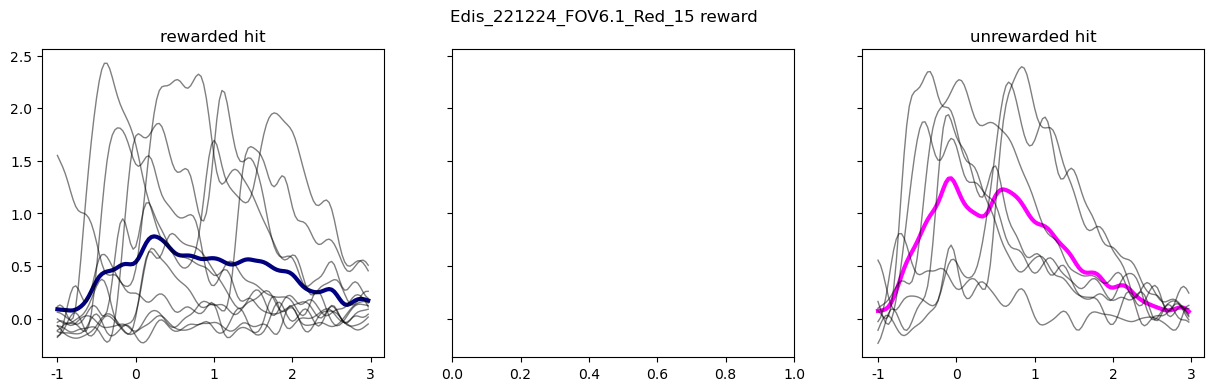

In [123]:
protocols = ['Edis']
channels = ['Red']
trialtypes = ['rewarded hit','rewarded FA','unrewarded hit']
colors = ['navy','cyan','magenta']
specific_ROIs = ['Edis_221224_FOV6.1_Red_15']
epoch = 'reward'
pre_window = 30
post_window = 90

plot_ROI_by_ROI_traces(cohort_epochs, protocols, channels, trialtypes, colors, specific_ROIs, epoch, pre_window, post_window)

## Extract pupil and calcium metrics from epochs/trial types of interest from all sessions ##
- ***Unit of analysis (UOA):*** ROI-by-ROI average for calcium metrics, trial-by-trial for pupil metrics
- ***Comparison datasets (nD):*** Each epoch from each protocol (e.g. reward epoch in novice reversal sessions) is a separate comparison dataset
- ***Comparison conditions (nC):*** Within each comparison dataset, compare different trial types (i.e. the comparison condition)
- ***Statistical comparisons (nD x nC):*** For each comparison dataset, average across all UOAs for each comparison condition, then compare between these conditions

In [ ]:
for dtype, dtype_dict in cohort_epochs.items():
    if dtype != 'deltaF':
        for epoch, epoch_dict in dtype_dict.items():
            print(epoch)
            epoch_df = pd.concat(epoch_dict)
            if epoch_df.shape[0] > 0:
                if dtype == 'pupil':
                    for UOA_label, UOA_name in zip(['Unique_trial','Unique session'], ['single_trials','session_by_session']):
                        pupil_dfs = {}
                        for ttype in ['rewarded hit','rewarded FA','unrewarded hit']:
                            ttype_df = epoch_df[(epoch_df.index.get_level_values('Final Outcome') == 'Tactile '+ttype) | (epoch_df.index.get_level_values('Final Outcome') == 'Auditory '+ttype)]
                            ttype_df = ttype_df.max(axis=1).to_frame()
                            UOA_groups = ttype_df.groupby(ttype_df.index.get_level_values(UOA_label))
                            pupil_dfs[ttype] = UOA_groups.mean()
                        pupil_df = pd.concat(pupil_dfs, axis=1)
                        pupil_df['Protocol'] = [x.split('_')[0] for x in list(pupil_df.index)]
                        pupil_df = pupil_df.reset_index().set_index([UOA_label,'Protocol']).droplevel(1, axis=1)
                        pupil_df.to_csv(data_directory+'\\'+('_').join([epoch,'peak_pupil',UOA_name,'.csv']))
                elif dtype == 'events':
                    UOA_label = 'Unique_ROI'
                    events_dfs = {}
                    epoch_df = epoch_df.reset_index().set_index(['level_0', UOA_label])
                    epoch_df['Timeout_end'] = epoch_df['Timeout_end'].replace({'-':8000})
                    epoch_df = epoch_df[['Response latency','Water_time','Timeout_end','Final Outcome','peak','ev_onset']]
                    for ttype in ['rewarded hit','rewarded FA','unrewarded hit']:
                        print(ttype)
                        ttype_df = epoch_df[(epoch_df['Final Outcome'] == 'Tactile '+ttype) | (epoch_df['Final Outcome'] == 'Auditory '+ttype)]
                        ttype_df = ttype_df.drop('Final Outcome',axis=1).astype(float)

                        if epoch == 'trial_onset':
                            ttype_df['ev_latency'] = ttype_df['ev_onset']
                        elif epoch == 'prestim':
                            ttype_df['ev_latency'] = ttype_df['ev_onset'] - 3
                        elif epoch == 'stimulus':
                            ttype_df['ev_latency'] = ttype_df['ev_onset'] - 3
                        elif epoch == 'response':
                            ttype_df['ev_latency'] = ttype_df['ev_onset'] - ttype_df['Response latency']/1000
                        elif 'reward' in epoch:
                            ttype_df['ev_latency'] = ttype_df['ev_onset'] - ttype_df['Water_time']/1000
                        elif epoch == 'ITI':
                            ttype_df['ev_latency'] = ttype_df['ev_onset'] - ttype_df['Timeout_end']/1000
                        else:
                            ttype_df['ev_latency'] = ttype_df['ev_onset']
                        UOA_groups = ttype_df.groupby([ttype_df.index.get_level_values(UOA_label), ttype_df.index.get_level_values('level_0')])
                        event_metrics = UOA_groups.mean()
                        event_counts = UOA_groups.size().to_frame()
                        all_deltaF = pd.concat(cohort_epochs['deltaF']['all'])
                        ttype_deltaF = all_deltaF[(all_deltaF.index.get_level_values('Final Outcome') == 'Tactile '+ttype) | (all_deltaF.index.get_level_values('Final Outcome') == 'Auditory '+ttype)]
                        mutual_deltaF = ttype_deltaF[ttype_deltaF.index.get_level_values('Unique_ROI').isin(event_counts.index.get_level_values('Unique_ROI').unique())]
                        trial_counts = mutual_deltaF.groupby(mutual_deltaF.index.get_level_values('Unique_ROI')).size().to_frame()
                        event_metrics['rate'] = list((event_counts/trial_counts)[0])
                        events_dfs[ttype] = event_metrics[['ev_latency','peak','rate']]
                    event_df = pd.concat(events_dfs, axis=1)
                    event_df = event_df.swaplevel(0,1,axis=1).sort_index(level=0, axis=1)
                    event_df['Protocol'] = [x.split('_')[0] for x in list(event_df.index.get_level_values(UOA_label))]
                    event_df['Channel'] = [x.split('_')[-2] for x in list(event_df.index.get_level_values(UOA_label))]
                    event_df['ID'] = event_df.index.get_level_values('level_0')
                    event_df = event_df.reset_index().set_index(['ID',UOA_label,'Protocol', 'Channel']).drop('level_0',axis=1)
                    event_df.to_csv(data_directory+'\\'+('_').join([epoch,'calcium_metrics.csv']))                    

In [48]:
# df = pd.read_csv(data_directory+'\\reward_calcium_metrics.csv', header=[0,1], index_col=[0,1,2,3])
# comparison_list = [['rewarded hit','rewarded FA']]
# metric = 'rate'
df = extracted_behavior['deltaF']['sesh_by_sesh']
comparison_list =[['Hit ant','FA ant'],['Hit rew','FA rew']]
t_test_pandas(df, comparison_list)

t-stat   p-value  nHit   nFA
Channel  Protocol Comparison                                        
Behavior Edet     Hit ant vs. FA ant  3.356831  0.002621  13.0  13.0
         Edis     Hit ant vs. FA ant  2.836627  0.009601  12.0  12.0
         Erev     Hit ant vs. FA ant  3.631368  0.003442   7.0   7.0
         Edet     Hit rew vs. FA rew  4.232166  0.000342  13.0  11.0
         Edis     Hit rew vs. FA rew  3.269261  0.003509  12.0  12.0
         Ndet     Hit rew vs. FA rew  4.795658  0.000285   9.0   7.0

In [ ]:
def redefine_outcomes(deltaF):
    final_outcomes = []
    for index, rows in deltaF.iterrows():
        rew = index[12]
        outcome = index[16]
        ttype = index[15]

        if ttype == float(1):
            if rew == float(1):
                final = 'Tactile rewarded '+outcome
            else:
                final = 'Tactile unrewarded '+outcome
        elif ttype == float(2):
            if rew == float(1):
                final = 'Auditory rewarded '+outcome
            else:
                final = 'Auditory unrewarded '+outcome        
        else:
            if rew == float(1):
                final = 'Catch rewarded '+outcome
            else:
                final = 'Catch unrewarded '+outcome           
        final_outcomes.append(final)
    
    deltaF.index = pd.MultiIndex.from_tuples([tuple(list(x) + [final_outcomes[i]]) for i, (x) in enumerate(deltaF.index)], names=deltaF.index.names+['Final Outcome'])           
    
    return deltaF

# FIGURE OUT HOW TO GROUPBY WITH LATENCY/WATER TIME AS NUMERIC VALUES

##

In [ ]:
all_pupil = pd.concat(cohort_pupil)
pupil_behavior = []
for mouse in all_pupil.index.get_level_values(0).unique():
    mouse_df = all_pupil[all_pupil.index.get_level_values(0) == mouse]
    for session in mouse_df.index.get_level_values('Unique session').unique():
        session_df = mouse_df[mouse_df.index.get_level_values('Unique session') == session]
        protocol = session_df.index.get_level_values('Protocol')[0]
        first_channel = session_df.index.get_level_values('Channel').unique()[0]
        first_channel_df = session_df[session_df.index.get_level_values('Channel') == first_channel]
        first_channel_df = first_channel_df.reset_index().iloc[:,:18]
        first_channel_df = first_channel_df.rename({'level_0':'ID'}, axis=1)
        first_channel_df['Anticipatory licks'] = [x+1 for x in list(first_channel_df['Anticipatory licks'])]
        first_channel_df['Response latency'] = [(float(x)/1000)-3 for x in list(first_channel_df['Response latency'].replace({'-':np.nan}))]
        if (len(first_channel_df['Trial type'].unique()) > 1) & (first_channel_df.shape[0] > 30):
            posteriors_df = pd.DataFrame(calculate_posteriors(first_channel_df, first_channel_df.shape[0], protocol, 'pupil')[0])
            prop_rare = posteriors_df['rare prob']['G']
            hit_rate = posteriors_df['response rate']['G']
            FA_rate = posteriors_df['response rate']['N']
            correct = first_channel_df[(first_channel_df.Outcome  == 'hit') | (first_channel_df.Outcome  == 'CR')].shape[0]
            CP_rate = correct/first_channel_df.shape[0]
            FA_latency = (first_channel_df[first_channel_df.Outcome == 'FA']['Response latency']).mean()
            hit_latency = (first_channel_df[first_channel_df.Outcome == 'hit']['Response latency']).mean()
            FA_licks = (first_channel_df[first_channel_df.Outcome == 'FA']['Anticipatory licks']).mean()
            hit_licks = (first_channel_df[first_channel_df.Outcome == 'hit']['Anticipatory licks']).mean()
            norm_licks = FA_licks/hit_licks
            FA_licks_rew = (first_channel_df[(first_channel_df.Outcome == 'FA') & (first_channel_df.Water == float(1))][' Reward licks']).mean()
            hit_licks_rew = (first_channel_df[(first_channel_df.Outcome == 'hit') & (first_channel_df.Water == float(1))][' Reward licks']).mean()
            final_df = pd.DataFrame([CP_rate, hit_rate, FA_rate, prop_rare, norm_licks, hit_licks, FA_licks, hit_licks_rew, FA_licks_rew, hit_latency, FA_latency, protocol], 
                                    index=['CP rate','Hit rate','FA rate','Rare outcome proportion','Hit/FA licks', 'Hit ant', 'FA ant', 'Hit rew','FA rew', 'Hit latency','FA latency', 'Protocol'], 
                                    columns=[mouse+'_'+session]).T
            final_df = final_df.reset_index().set_index(['index','Protocol'])
            pupil_behavior.append(final_df)
pupil_behavior = pd.concat(pupil_behavior)
pupil_behavior.index = pupil_behavior.index.set_names('FOV',level=0)

In [ ]:
all_deltaF = pd.concat(cohort_deltaF)
deltaF = redefine_outcomes(all_deltaF)
expectation = []
for index, rows in deltaF.iterrows():
    t = index[20]
    if t in ['Tactile rewarded hit', 'Auditory rewarded hit', 'Tactile unrewarded FA', 'Auditory unrewarded FA']:
        expectation.append('expected')
    elif t in ['Tactile rewarded FA', 'Auditory rewarded FA', 'Tactile unrewarded hit', 'Auditory unrewarded hit']:
        expectation.append('unexpected')
    else:
        expectation.append('no expectation')
deltaF['expectation'] = expectation
values = [x+(y,) for x,y in zip(deltaF.index.values, deltaF['expectation'])]
names = list(deltaF.index.names)
names.append('expectation')
deltaF.index = pd.MultiIndex.from_tuples(values, names=names)
deltaF = deltaF.iloc[:,:-1]

In [ ]:
imaging_behavior = []
imaging_behavior_rates = []
for mouse in deltaF.index.get_level_values(0).unique():
    mouse_df = deltaF[deltaF.index.get_level_values(0) == mouse]
    for session in mouse_df.index.get_level_values('Unique session').unique():
        session_df = mouse_df[mouse_df.index.get_level_values('Unique session') == session]
        protocol = session_df.index.get_level_values('Protocol')[0]
        first_ROI = session_df.index.get_level_values('ROI').unique()[0]
        first_ROI_df = session_df[session_df.index.get_level_values('ROI') == first_ROI]
        if first_ROI_df.shape[0] > 30:
            first_ROI_df = first_ROI_df.reset_index().iloc[:,:22]
            first_ROI_df = first_ROI_df.rename({'level_0':'ID'}, axis=1)
            first_ROI_df['Anticipatory licks'] = [x+1 for x in list(first_ROI_df['Anticipatory licks'])]
            first_ROI_df['Response latency'] = [(float(x)/1000)-3 for x in list(first_ROI_df['Response latency'].replace({'-':np.nan}))]
            imaging_behavior.append(first_ROI_df)

            posteriors_df = pd.DataFrame(calculate_posteriors(first_ROI_df, first_ROI_df.shape[0], protocol, 'calcium')[0])
            prop_rare = posteriors_df['reward prob']['N'] / posteriors_df['reward prob']['G']
            hit_rate = posteriors_df['response rate']['G']
            FA_rate = posteriors_df['response rate']['N']
            correct = first_ROI_df[(first_ROI_df.Outcome  == 'hit') | (first_ROI_df.Outcome  == 'CR')].shape[0]
            CP_rate = correct/first_ROI_df.shape[0]
            FA_latency = (first_ROI_df[first_ROI_df.Outcome == 'FA']['Response latency']).mean()
            hit_latency = (first_ROI_df[first_ROI_df.Outcome == 'hit']['Response latency']).mean()
            FA_licks = (first_ROI_df[first_ROI_df.Outcome == 'FA']['Anticipatory licks']).mean()
            hit_licks = (first_ROI_df[first_ROI_df.Outcome == 'hit']['Anticipatory licks']).mean()
            norm_licks = FA_licks/hit_licks
            FA_licks_rew = (first_ROI_df[(first_ROI_df.Outcome == 'FA') & (first_ROI_df.Water == float(1))]['Reward licks']).mean()
            hit_licks_rew = (first_ROI_df[(first_ROI_df.Outcome == 'hit') & (first_ROI_df.Water == float(1))]['Reward licks']).mean()
            final_df = pd.DataFrame([CP_rate, hit_rate, FA_rate, prop_rare, norm_licks, FA_licks, hit_licks, FA_licks_rew, hit_licks_rew, hit_latency, FA_latency, protocol], 
                                    index=['CP rate','Hit rate','FA rate','Rare outcome proportion','Hit/FA licks', 'Hit ant', 'FA ant', 'Hit rew','FA rew', 'Hit latency','FA latency', 'Protocol'], 
                                    columns=[mouse+'_'+session]).T
            final_df = final_df.reset_index().set_index(['index','Protocol'])
            imaging_behavior_rates.append(final_df)
imaging_behavior = pd.concat(imaging_behavior)
imaging_behavior_rates = pd.concat(imaging_behavior_rates)
imaging_behavior_rates.index = imaging_behavior_rates.index.set_names('FOV',level=0)
imaging_behavior_rates.to_csv(data_directory+'\\imaging_behavior.csv')

In [ ]:
cohort_epochs['pupil'].keys()

## Make this previous trial, and add correlated/uncorrelated ROI label
## Then try outcome encoding averaged over the last 10 trials for each ROI as an individual feature instead

In [ ]:
both_channels = []
for channel, channel_dict in all_single_trials.items():
    channel_df = pd.concat(channel_dict)
    channel_df = channel_df[channel_df.index.get_level_values(0) == 'all']
    for index, rows in channe
#     both_channels.append(channel_df)
# both_df = pd.concat(both_channels)
# both_df['ev_latency'] = both_df['ev_onset'] - both_df['inferred']
# both_df.to_csv('reward_all_single_trials.csv')
        
#     if rows['Response latency'] isnan == True:
#     print(type(rows['Response latency']))
#     channel_df.to_csv(channel+'_delayed_reward_single_trial_correlations.csv')

In [ ]:
somas = {'RGECO_GCamP_Batch2_five':[],'RGECO_GCamP_Batch2_three':['FOV4']} #somatic recording sessions (to remove from "Red" channel data)

FOV_norm_means = {}
all_reward_events = pd.concat(all_event_rates, axis=1)
all_reward_events
all_reward_events = all_reward_events.replace({0:np.nan})
for soma, soma_list in somas.items():
    if len(soma_list) == 0:
        all_reward_events = all_reward_events[~(all_reward_events.index.get_level_values(0).str.contains(soma))]
    else:
        FOV = soma_list[0]
        all_reward_events = all_reward_events[~((all_reward_events.index.get_level_values(0).str.contains(soma)) & (all_reward_events.index.get_level_values(0).str.contains(FOV)))]
all_reward_events = all_reward_events[~(all_reward_events.index.get_level_values(0).str.contains('RGECO_GCamP_Batch1_muji_Edis_221104_FOV3.1'))]

for channel in ['Red','Green']:
    channel_df = all_reward_events[all_reward_events.index.get_level_values(0).str.contains(channel)]
    correlated_dfs = []
    uncorrelated_dfs =[]
    for index, rows in channel_df.iterrows():
        mouse = ('_').join(index[0].split('_')[:4])
        ROI = index[0].split(mouse)[1][1:]

        if len(correlated_ROIs[mouse].keys()) > 0:
            if ROI in correlated_ROIs[mouse].keys():
                correlated_dfs.append(rows.to_frame().T)
            else:
                uncorrelated_dfs.append(rows.to_frame().T)
        else:
                uncorrelated_dfs.append(rows.to_frame().T)            
    correlated_df = pd.concat(correlated_dfs)
    correlated_df.index.names = channel_df.index.names
    uncorrelated_df = pd.concat(uncorrelated_dfs)
    uncorrelated_df.index.names = channel_df.index.names
    
    for label, df in zip(['correlated_ROIs','uncorrelated_ROIs','ALL_ROIs'], [correlated_df, uncorrelated_df, channel_df]):
        df['FOV'] = [('_').join(x.split('_')[:-2]) for x in list(df.index.get_level_values('Final index'))]
        df = df.reset_index().set_index(['FOV','Final index','Protocol'])
        FOV_means = df.groupby([df.index.get_level_values('FOV'), df.index.get_level_values('Protocol')]).mean()
        norm_type = {}
        for ttype in FOV_means.columns:
            norm_type[ttype] = FOV_means['rewarded hit']
        normalizer = pd.concat(norm_type, axis=1)
        norm_df = df.div(normalizer)
        if label == 'ALL_ROIs':
#             protocol_df = norm_df[(norm_df.index.get_level_values('Protocol').str.contains('dis')) | (norm_df.index.get_level_values('Protocol').str.contains('rev'))]
            protocol_df = norm_df
            FOV_norms = protocol_df.groupby([protocol_df.index.get_level_values('FOV'), protocol_df.index.get_level_values('Protocol')]).mean()
            correlation_df = pd.merge(FOV_norms, imaging_behavior, left_index=True, right_index=True)
            correlation_df = correlation_df[['rewarded FA', 'unrewarded hit', 'rewarded hit','CP rate','Hit rate','FA rate','Rare outcome proportion','Hit/FA licks']]
            correlation_df.to_csv(channel+'_behavior_population_reward_calcium_correlation.csv')
            df.to_csv(('_').join([label,channel,'reward_event_rate.csv']))
            norm_df.to_csv(('_').join([label,channel,'reward_NORM_event_rate.csv']))
        else:
            df.to_csv(('_').join([label,str(event_thresh),channel,'reward_event_rate.csv']))
            norm_df.to_csv(('_').join([label,str(event_thresh),channel,'reward_NORM_event_rate.csv']))

In [ ]:
if 'deltaF_pupil.npy' in os.listdir(cwd):
    print('deltaF_pupil.npy file found')
    print('deltaF_pupil.npy file uploading now...')
    deltaF_pupil = np.load('deltaF_pupil.npy', allow_pickle=True)
    print('finished uploading')

else:
    print('deltaF_pupil.npy file not found')
    print('deltaF_pupil.npy file creating now...')    
    import time
    start = time.time()

    deltaF_df = pd.concat(cohort_deltaF)
    pupil_df = pd.concat(cohort_pupil)
    deltaF_pupil = {}
    mouse_groups = deltaF_df.groupby(deltaF_df.index.get_level_values(0))
    for mouse in deltaF_df.index.get_level_values(0).unique():
        deltaF_pupil[mouse] = {}
        mouse_df = mouse_groups.get_group(mouse)
        ROI_groups = mouse_df.groupby(mouse_df.index.get_level_values('Unique_ROI'))
        mouse_correlation = {}

        for i, (ROI) in enumerate(mouse_df.index.get_level_values('Unique_ROI').unique()):
            ROI_df = ROI_groups.get_group(ROI)
            deltaF_list = []
            pupil_list = []
            df_dict = {}
            for j, (index, rows) in enumerate(ROI_df.iterrows()):
                midx_number = np.where(np.asarray(ROI_df.index.names) == 'Unique_trial')[0][0]
                unique_trial = index[midx_number]
                mouse_pupil = pupil_df[pupil_df.index.get_level_values(0) == mouse]

                if unique_trial in mouse_pupil.index.get_level_values('Unique_trial'):
                    trial_pupil = np.asarray(mouse_pupil[mouse_pupil.index.get_level_values('Unique_trial') == unique_trial].iloc[0])
                    downsampled_pupil = np.asarray([np.mean(x) for x in list(split(trial_pupil, rows.shape[0]))])
                    trial_df = pd.DataFrame([np.asarray(rows), downsampled_pupil], index=['deltaF', 'pupil']).T
                    df_dict[unique_trial] = trial_df
            mouse_correlation = pd.concat(df_dict) if len(df_dict.keys()) > 0 else pd.DataFrame([], index=['deltaF', 'pupil']).T
            deltaF_pupil[mouse][ROI] = mouse_correlation
    pickle.dump(deltaF_pupil, open("deltaF_pupil.npy", "wb"))

    end = time.time()
    print(end-start, 'seconds taken to create')

In [ ]:
for epoch, epoch_dict in cohort_epochs['pupil'].items():
    if epoch == 'all':
        epoch_df = pd.concat(epoch_dict).dropna(how='all')
        dfs = []
        for index, rows in epoch_df.iterrows():
            water = index[12]
            lick = index[7]
            
            if lick == '-':
                water = 4500
            else:
                if water == '-':
                    water = int(lick)+1000
                else:
                    water = int(water)
            water_fps = math.floor(water/1000*30*30)
            dfs.append(rows.iloc[water_fps:water_fps+1800].to_numpy())
        df = pd.DataFrame(dfs, index=epoch_df.index, columns=list(range(900)))
        
        peak_df = df.max(axis=1).to_frame()
        peak_df['Response latency'] = peak_df.index.get_level_values('Response latency')
        peak_df['Prestim licks'] = peak_df.index.get_level_values('Prestim licks')
        peak_df['Anticipatory licks'] = peak_df.index.get_level_values('Anticipatory licks')
        peak_df['Reward licks'] = peak_df.index.get_level_values(' Reward licks')
        peak_df = peak_df.droplevel(['Response latency','Prestim licks','Anticipatory licks',' Reward licks'])
        peak_df = peak_df.rename({0:'Peak dilation'}, axis=1)

        ttype_peaks = []
        for t in ['rewarded hit', 'unrewarded hit', 'rewarded FA', 'unrewarded FA']:
            if t in ['rewarded hit','rewarded FA']:
                ttype_peak = peak_df[(peak_df.index.get_level_values('Final Outcome') == 'Tactile '+t) | (peak_df.index.get_level_values('Final Outcome') == 'Auditory '+t)].T
            else:    
                ttype_peak = peak_df[peak_df.index.get_level_values('Final Outcome').str.contains(t)].T
            ttype_peak.index = pd.MultiIndex.from_tuples((x,y) for x,y in zip(ttype_peak.index, [t]*ttype_peak.shape[0]))
            ttype_peak = ttype_peak.T.droplevel('Final Outcome')
            ttype_peaks.append(ttype_peak)
        ttype_peak_df = pd.concat(ttype_peaks, axis=1).sort_index(level=0, axis=1)
    ttype_peak_df.to_csv('delayed_reward_SINGLE_TRIAL_PUPIL.csv')

    sesh_by_sesh = ttype_peak_df.groupby([ttype_peak_df.index.get_level_values(0), ttype_peak_df.index.get_level_values('Unique session'), ttype_peak_df.index.get_level_values('Protocol')]).mean()
    sesh_by_sesh['sesh'] = sesh_by_sesh.index.get_level_values(0) + '_' + sesh_by_sesh.index.get_level_values('Unique session')
    sesh_by_sesh.to_csv('delayed_reward_sesh_by_sesh_PUPIL.csv')

In [ ]:
for epoch, epoch_dict in cohort_epochs['events'].items():
    if epoch == 'all':
        epoch_df = pd.concat(epoch_dict)
        
        for soma, soma_list in somas.items():
            if len(soma_list) == 0:
                epoch_df = epoch_df[epoch_df.index.get_level_values(0) != soma]
            else:
                FOV = soma_list[0]
                epoch_df = epoch_df[~((epoch_df.index.get_level_values(0).str.contains(soma)) & (epoch_df['FOV'].str.contains(FOV)))]
        

        deltaF_df = pd.concat(cohort_epochs['deltaF'][epoch])
        deltaF_dfs = []
        for index, rows in deltaF_df.iterrows():
            water = index[12]
            lick = index[7]

            if lick == '-':
                water = 4500
            else:
                if water == '-':
                    water = int(lick)+1000
                else:
                    water = int(water)
            water_fps = math.floor(water/1000*30.3)
            deltaF_dfs.append(rows.iloc[water_fps:water_fps+30].to_numpy())
        deltaF_df = pd.DataFrame(deltaF_dfs, index=deltaF_df.index, columns=list(range(30)))
        
        for protocol in ['Ndet','Ndis', 'Nrev']:
            plt.figure()
            legends = []
            for t, c in zip(['rewarded hit', 'unrewarded hit', 'rewarded FA', 'unrewarded FA'], ['navy','magenta','cyan','orange']):
                ttype_df = deltaF_df[(deltaF_df.index.get_level_values('Final Outcome') == 'Tactile '+t) | (deltaF_df.index.get_level_values('Final Outcome') == 'Auditory '+t)]
                ttype_df = ttype_df[ttype_df.index.get_level_values('Protocol') == protocol]
                ttype_df = ttype_df[ttype_df.index.get_level_values('Channel') == 'Red']
                plt.plot(list(range(30)), ttype_df.mean(), color=c)
                plt.fill_between(list(range(30)), ttype_df.mean()-ttype_df.sem(), ttype_df.mean()+ttype_df.sem(), color=c, alpha=0.5)
                legends.append(t)
                legends.append(t)
            plt.legend(legends)
            plt.suptitle(protocol)


#         correlated_dfs = []
#         for index, rows in epoch_df.iterrows():
#             mouse = index[0]
#             ROI = rows['Unique_ROI']

#             if len(correlated_ROIs[mouse].keys()) > 0:
#                 if ROI in correlated_ROIs[mouse].keys():
#                     correlated_dfs.append(rows.to_frame().T)

#         if len(correlated_dfs) == 0:
#             correlated_df = epoch_df
#         else:
#             correlated_df = pd.concat(correlated_dfs)
#             correlated_df.index.names = correlated_df.index.names

#         for label, df in zip(['ALL_ROIs','correlated_ROIs'],[epoch_df, correlated_df]):
#             if label == 'ALL_ROIs':
#                 epoch_event_rates = []
#                 epoch_event_metrics_list = []
#                 plt.figure()
#                 legends = []
#                 for t in ['rewarded hit', 'unrewarded hit', 'rewarded FA', 'unrewarded FA']:
#                     ttype_events = df[(df['Final Outcome'] == 'Tactile '+t) | (df['Final Outcome'] == 'Auditory '+t)]
#                     ROI_event_count = ttype_events.groupby([ttype_events.index.get_level_values(0), 'Unique_ROI', 'Protocol']).size()
#                     plt.hist(ROI_event_count, alpha=0.5)
#                     legends.append(t)
#                 plt.legend(legends)
#                 ROI_deltaF_df = deltaF_df[deltaF_df.index.get_level_values('Unique_ROI').isin(list(ROI_event_count.index.get_level_values('Unique_ROI')))]
#                 ttype_deltaF = ROI_deltaF_df[ROI_deltaF_df.index.get_level_values('Final Outcome').str.contains(t)]
#                 ROI_trial_count = ttype_deltaF.groupby([ttype_deltaF.index.get_level_values(0), ttype_deltaF.index.get_level_values('Unique_ROI'), ttype_deltaF.index.get_level_values('Protocol')]).size()
#                 ROI_event_rate = ROI_event_count / ROI_trial_count
#                 ROI_event_rate_df = pd.DataFrame(ROI_event_rate.values, index=ROI_event_rate.index, columns=[t])
#                 epoch_event_rates.append(ROI_event_rate_df)
#                 epoch_event_means = ttype_events.groupby([ttype_events.index.get_level_values(0), 'Unique_ROI', 'Final Outcome','Protocol']).mean()

#                 outcome_df = ttype_events.groupby([ttype_events.index.get_level_values(0),ttype_events['Unique_ROI'], ttype_events['Protocol']]).mean().T.reset_index()
#                 outcome_df.index = pd.MultiIndex.from_tuples([(x,y) for x,y in zip(outcome_df['index'], [t]*outcome_df.shape[0])])
#                 outcome_df = outcome_df.T
#                 epoch_event_metrics_list.append(outcome_df)
#             epoch_event_metrics = pd.concat(epoch_event_metrics_list, axis=1).T

#             epoch_event_metric_list = []
#             for metric in ['response latency', 'Prestim licks', 'Anticipatory licks', 'Reward licks', 'Stimulus', 'peak', 'ev_onset', 'peak_time', 'integral']:
#                 metric_df = epoch_event_metrics[epoch_event_metrics.index.get_level_values(0) == metric]
#                 epoch_event_metric_list.append(metric_df)
#             epoch_event_metrics = pd.concat(epoch_event_metric_list).T
#             epoch_event_rate = pd.concat(epoch_event_rates, axis=1)

#             for channel in ['Red','Green']:
#                 channel_epoch_event_rate = epoch_event_rate[epoch_event_rate.index.get_level_values('Unique_ROI').str.contains(channel)]
#                 channel_epoch_event_metrics = epoch_event_metrics[epoch_event_metrics.index.get_level_values('Unique_ROI').str.contains(channel)]

#                 channel_epoch_event_rate.to_csv(('_').join([label,channel,epoch,'event_rate.csv']))
#                 channel_epoch_event_metrics.to_csv(('_').join([label,channel,epoch,'event_metrics.csv']))

## Plotting functions

In [ ]:
def plot_pupil(data, epochs, protocols, outcomes, plottype, trials, event_epochs=None):
    data = data['pupil']
    if type(epochs) == str:
        if epochs == 'all':
            epochs = data.keys()
    else:   
        epochs = epochs
        
    for epoch, epoch_dict in data.items():
        if epoch in epochs:
            epoch_df = pd.concat(epoch_dict)
            epoch_df = epoch_df[epoch_df.index.get_level_values('Stimulus') != float(3)]   
            
            if type(protocols) == str:
                if protocols == 'all':
                    protocols = ['N','E'] + list(epoch_df.index.get_level_values('Protocol').unique())
            else:
                protocols = protocols
            
            for protocol in protocols:
                view_outcomes = []
                labels = []
                
                for outcome in outcomes:
                    if (outcomes == ['FA', 'hit']) | (outcomes == ['hit', 'FA']):
                        for label, reward in zip(['rewarded', 'unrewarded'],[float(1), float(0)]):
                            rew_df = epoch_df[epoch_df.index.get_level_values('Water') == reward]
                            out_df = rew_df[rew_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                            view_outcomes.append(out_df)
                            labels.append(label+' '+outcome)
                    else:
                            out_df = epoch_df[epoch_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                            view_outcomes.append(out_df)
                            labels.append(outcome)                            
                
                n = len(view_outcomes)
                fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(5*n,3), sharey=True)
                if plottype == 'trials':
                    color = cm.rainbow(np.linspace(0, 1, n)) 
                    for col, (outcome_df, color, label) in enumerate(zip(view_outcomes, color, labels)):
                        outcome_df = outcome_df[outcome_df.index.get_level_values('Protocol').str.contains(protocol)]
                        
                        if trials == 'events':
                            outcome_df = get_event_trials(outcome_df, 'pupil', event_epochs)
                        else:
                            outcome_df = outcome_df
                        
                        nmice = len(outcome_df.index.get_level_values(0).unique())
                        nsessions = len(outcome_df.index.get_level_values('Unique session').unique())
                        mouse_counts = {}
                        for mouse in outcome_df.index.get_level_values(0).unique():
                            mouse_counts[mouse] = len(outcome_df[outcome_df.index.get_level_values(0) == mouse].index.get_level_values('Unique_trial').unique())
                            
                        unique = outcome_df.groupby(outcome_df.index.get_level_values('Unique_trial')).mean()
                        ntrials = unique.shape[0]
                        mean = unique.mean()
                        sem = unique.sem()
                        ax[col].plot(mean, color=color)
                        ax[col].fill_between(x=list(range(unique.shape[1])), y1=mean-sem, y2=mean+sem, color=color, alpha=0.5)
                        if epoch == 'all':
                            ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                            ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                        else:
                            ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                            ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])
                        
                        title = str(nsessions)+' sessions/'+str(ntrials)+' trials \n '                     
                        for i, (key, value) in enumerate(mouse_counts.items()):
                            title += ' \n '+key+': '+str(value)+' trials'
                        ax[col].set_title(title)
                        ax[col].legend([label])
                        
                else:
                    legends = []
                    for col, (outcome_df, label) in enumerate(zip(view_outcomes, labels)):
                        outcome_df = outcome_df[outcome_df.index.get_level_values('Protocol').str.contains(protocol)]
                        
                        if trials == 'events':
                            outcome_df = get_event_trials(outcome_df, 'pupil', event_epochs)
                        else:
                            outcome_df = outcome_df
                            
                        nmice = len(list(outcome_df.index.get_level_values(0).unique()))
                        color = cm.rainbow(np.linspace(0,1,nmice))                        
                        unique = outcome_df.groupby(outcome_df.index.get_level_values(0)).mean() 
                        
                        for j, ((color), (index, rows)) in enumerate(zip(color, unique.iterrows())):
                            ax[col].plot(rows, color=ID_colors[index])
                            if epoch == 'all':
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                                ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                            else:
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                                ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])                
                            ax[col].set_title(label)
                            legends.append(index)
                        ax[col].legend(legends, prop={'size': 6})
                if trials == 'all':
                    plt.suptitle(protocol+' '+epoch+' epoch (Pupil) using all trials', fontsize=25, y=1.5)
                else:
                    plt.suptitle(protocol+' '+epoch+' epoch (Pupil) using only trials with '+event_epochs+' events', fontsize=25, y=1.5)
                plt.ylim(0.94,1.2)
                fig.savefig(protocol+'_pupil.svg')

In [ ]:
def plot_calcium(data, channel, epochs, protocols, outcomes, plottype, trials, event_epochs=None):
    data = data['deltaF']

    if type(epochs) == str:
        if epochs == 'all':
            data.keys()
    else:   
        epochs = epochs
        
    for epoch, epoch_dict in data.items():
        if epoch in epochs:
            epoch_df = pd.concat(epoch_dict)
            epoch_df = epoch_df[epoch_df.index.get_level_values('Stimulus') != float(3)]  
            
            groups = epoch_df.groupby(epoch_df.index.get_level_values(0))
            for group in epoch_df.index.get_level_values(0).unique():
                group_df = groups.get_group(group)
            epoch_df = epoch_df[epoch_df.index.get_level_values('Channel') == channel]
            
            if channel == 'Green':
                epoch_df = epoch_df
            else:
                for soma, soma_list in somas.items():
                    if len(soma_list) == 0:
                        epoch_df = epoch_df[epoch_df.index.get_level_values(0) != soma]
                    else:
                        FOV = soma_list[0]
                        epoch_df = epoch_df[~((epoch_df.index.get_level_values(0).str.contains(soma)) & (epoch_df.index.get_level_values('FOV').str.contains(FOV)))]
            
            if type(protocols) == str:
                if protocols == 'all':
                    protocols = ['N','E'] + list(epoch_df.index.get_level_values('Protocol').unique())
            else:
                protocols = protocols
            
            for protocol in protocols:
                view_outcomes = []
                labels = []
                for outcome in outcomes:
                    if (outcomes == ['FA', 'hit']) | (outcomes == ['hit', 'FA']):
                        if epoch in ['reward', 'ITI', 'delayed_reward', 'all']:
                            for label, reward in zip(['rewarded', 'unrewarded'],[float(1), float(0)]):
                                rew_df = epoch_df[epoch_df.index.get_level_values('Water') == reward]
                                out_df = rew_df[rew_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                                view_outcomes.append(out_df)
                                labels.append(label+' '+outcome)
                        else:
                            out_df = epoch_df[epoch_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                            view_outcomes.append(out_df)
                            labels.append(outcome)     
                    elif outcome == 'rewarded':
                        out_df = epoch_df[epoch_df.index.get_level_values('Water') == float(1)]
                        view_outcomes.append(out_df)
                        labels.append(outcome)   
                    elif outcome == 'unrewarded':                        
                        out_df = epoch_df[epoch_df.index.get_level_values('Water') == float(0)]
                        view_outcomes.append(out_df)
                        labels.append(outcome)                           
                    else:
                            out_df = epoch_df[epoch_df.index.get_level_values('Final Outcome').str.contains(outcome)]
                            view_outcomes.append(out_df)
                            labels.append(outcome)                   
                n = len(view_outcomes)
                fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(5*n,3), sharey=True)
                if plottype == 'ROIs':
                    color = cm.rainbow(np.linspace(0, 1, n)) 
                    for col, (outcome_df, color, label) in enumerate(zip(view_outcomes, color, labels)):
                        if protocol =='E2':
                            outcome_df = outcome_df[(outcome_df.index.get_level_values('Protocol') == 'Edis') | (outcome_df.index.get_level_values('Protocol') == 'Erev')]
                        elif protocol =='N2':
                            outcome_df = outcome_df[(outcome_df.index.get_level_values('Protocol') == 'Ndis') | (outcome_df.index.get_level_values('Protocol') == 'Nrev')]
                        elif protocol == 'dynamic':
                            outcome_df = outcome_df          
                        elif protocol == 'stable':
                            outcome_df = outcome_df
                        else:
                            outcome_df = outcome_df[outcome_df.index.get_level_values('Protocol').str.contains(protocol)]
                        
#                         if protocol == 'dynamic':
#                             outcome_dfs = []
#                             sessions = outcome_df.groupby(outcome_df.index.get_level_values('Unique session'))
#                             for sesh in outcome_df.index.get_level_values('Unique session').unique():
#                                 shortened_sesh = sesh.split('FOV')[0][:-1]
#                                 sesh_df = sessions.get_group(sesh)
#                                 check_ID = sesh_df.index.get_level_values(0)[0]
#                                 for dysesh in short_term_strategy:
#                                     if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
#                                         outcome_dfs.append(sesh_df)
#                             outcome_df = pd.concat(outcome_dfs)
#                         elif protocol == 'stable':
#                             dynamic_seshes = []
#                             sessions = outcome_df.groupby(outcome_df.index.get_level_values('Unique session'))
#                             for sesh in outcome_df.index.get_level_values('Unique session').unique():
#                                 shortened_sesh = sesh.split('FOV')[0][:-1]
#                                 sesh_df = sessions.get_group(sesh)
#                                 check_ID = sesh_df.index.get_level_values(0)[0]
#                                 for dysesh in short_term_strategy:
#                                     if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
#                                         dynamic_seshes.append(sesh)

#                             outcome_dfs = []
#                             for sesh in outcome_df.index.get_level_values('Unique session').unique():
#                                 sesh_df = sessions.get_group(sesh)
#                                 if sesh in dynamic_seshes:
#                                     None
#                                 else:
#                                     outcome_dfs.append(sesh_df)
#                             outcome_df = pd.concat(outcome_dfs)
#                         else:
#                             outcome_df = outcome_df  
                            
                        if trials == 'events':
                            outcome_df = get_event_trials(outcome_df, 'deltaF', event_epochs)
                        else:
                            outcome_df = outcome_df
                        
                        mouse_counts = {}
                        
                        for mouse in outcome_df.index.get_level_values(0).unique():
                            mouse_counts[mouse] = len(outcome_df[outcome_df.index.get_level_values(0) == mouse].index.get_level_values('Unique_ROI').unique())
                            
                        nmice = len(outcome_df.index.get_level_values(0).unique())
                        nsessions = len(outcome_df.index.get_level_values('Unique session').unique())
                        
                        unique = outcome_df.groupby(outcome_df.index.get_level_values('Unique_ROI')).mean()
                        nROIs = unique.shape[0]
                        mean = unique.mean()
                        sem = unique.sem()
                        ax[col].plot(mean, color=color)
                        ax[col].fill_between(x=list(range(unique.shape[1])), y1=mean-sem, y2=mean+sem, color=color, alpha=0.5)
                        
                        if epoch == 'all':
                            ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                            ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                        else:
                            ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                            ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])
                        title = str(nsessions)+' sessions/'+str(nROIs)+' ROIs \n '
                        
                        for i, (key, value) in enumerate(mouse_counts.items()):
                            title += ' \n '+key+': '+str(value)+' ROIs'
                        ax[col].set_title(title)
                        ax[col].legend([label])
                elif plottype == 'mice':
                    legends = []
                    for col, (outcome_df, label) in enumerate(zip(view_outcomes, labels)):
                        if protocol =='E2':
                            outcome_df = outcome_df[(outcome_df.index.get_level_values('Protocol') == 'Edis') | (outcome_df.index.get_level_values('Protocol') == 'Erev')]
                        elif protocol =='N2':
                            outcome_df = outcome_df[(outcome_df.index.get_level_values('Protocol') == 'Ndis') | (outcome_df.index.get_level_values('Protocol') == 'Nrev')]
                        else:
                            outcome_df = outcome_df[outcome_df.index.get_level_values('Protocol').str.contains(protocol)]                        
                        
                        if trials == 'events':
                            outcome_df = get_event_trials(outcome_df, 'deltaF', event_epochs)
                        else:
                            outcome_df = outcome_df
                            
                        nmice = len(list(outcome_df.index.get_level_values(0).unique()))
                        color = cm.rainbow(np.linspace(0,1,nmice))                        
                        unique = outcome_df.groupby(outcome_df.index.get_level_values(0)).mean() 
                        
                        for j, ((color), (index, rows)) in enumerate(zip(color, unique.iterrows())):
                            ax[col].plot(rows, color=ID_colors[index])
                            if epoch == 'all':
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                                ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                            else:
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                                ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])              
                            ax[col].set_title(label)
                            legends.append(index)
                        ax[col].legend(legends, prop={'size': 6})
                else:
                    color = cm.rainbow(np.linspace(0, 1, n)) 
                    for col, (uncorrelated_df, color, label) in enumerate(zip(view_outcomes, color, labels)):
                        if protocol =='E2':
                            uncorrelated_df = uncorrelated_df[(uncorrelated_df.index.get_level_values('Protocol') == 'Edis') | (uncorrelated_df.index.get_level_values('Protocol') == 'Erev')]
                        elif protocol =='N2':
                            uncorrelated_df = uncorrelated_df[(uncorrelated_df.index.get_level_values('Protocol') == 'Ndis') | (uncorrelated_df.index.get_level_values('Protocol') == 'Nrev')]
                        elif protocol == 'dynamic':
                            uncorrelated_df = uncorrelated_df          
                        elif protocol == 'stable':
                            uncorrelated_df = uncorrelated_df
                        else:
                            uncorrelated_df = uncorrelated_df[uncorrelated_df.index.get_level_values('Protocol').str.contains(protocol)]
                        
#                         if protocol == 'dynamic':
#                             uncorrelated_dfs = []
#                             sessions = uncorrelated_df.groupby(uncorrelated_df.index.get_level_values('Unique session'))
#                             for sesh in uncorrelated_df.index.get_level_values('Unique session').unique():
#                                 shortened_sesh = sesh.split('FOV')[0][:-1]
#                                 sesh_df = sessions.get_group(sesh)
#                                 check_ID = sesh_df.index.get_level_values(0)[0]
#                                 for dysesh in short_term_strategy:
#                                     if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
#                                         uncorrelated_dfs.append(sesh_df)
#                             uncorrelated_df = pd.concat(uncorrelated_dfs)
#                         elif protocol == 'stable':
#                             dynamic_seshes = []
#                             sessions = uncorrelated_df.groupby(uncorrelated_df.index.get_level_values('Unique session'))
#                             for sesh in uncorrelated_df.index.get_level_values('Unique session').unique():
#                                 shortened_sesh = sesh.split('FOV')[0][:-1]
#                                 sesh_df = sessions.get_group(sesh)
#                                 check_ID = sesh_df.index.get_level_values(0)[0]
#                                 for dysesh in short_term_strategy:
#                                     if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
#                                         dynamic_seshes.append(sesh)

#                             uncorrelated_dfs = []
#                             for sesh in uncorrelated_df.index.get_level_values('Unique session').unique():
#                                 sesh_df = sessions.get_group(sesh)
#                                 if sesh in dynamic_seshes:
#                                     None
#                                 else:
#                                     uncorrelated_dfs.append(sesh_df)
#                             uncorrelated_df = pd.concat(uncorrelated_dfs)
#                         else:
#                             uncorrelated_df = uncorrelated_df                         
                        
                        outcome_dfs = []
                        for index, rows in uncorrelated_df.iterrows():
                            mouse = index[0]
                            ROI = index[19]
                            
                            if len(correlated_ROIs[mouse].keys()) > 0:
                                if ROI in correlated_ROIs[mouse].keys():
                                    outcome_dfs.append(rows.to_frame().T)
                        
                        if len(outcome_dfs) == 0:
                            None
                        else:
                            outcome_df = pd.concat(outcome_dfs)
                            outcome_df.index.names = uncorrelated_df.index.names

                            if trials == 'events':
                                outcome_df = get_event_trials(outcome_df, 'deltaF', event_epochs)
                            else:
                                outcome_df = outcome_df

                            mouse_counts = {}

                            for mouse in outcome_df.index.get_level_values(0).unique():
                                mouse_counts[mouse] = len(outcome_df[outcome_df.index.get_level_values(0) == mouse].index.get_level_values('Unique_ROI').unique())

                            nmice = len(outcome_df.index.get_level_values(0).unique())
                            nsessions = len(outcome_df.index.get_level_values('Unique session').unique())

                            unique = outcome_df.groupby(outcome_df.index.get_level_values('Unique_ROI')).mean()
                            nROIs = unique.shape[0]
                            mean = unique.mean()
                            sem = unique.sem()
                            ax[col].plot(mean, color=color)
                            ax[col].fill_between(x=list(range(unique.shape[1])), y1=mean-sem, y2=mean+sem, color=color, alpha=0.5)

                            if epoch == 'all':
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],13))
                                ax[col].set_xticklabels([int(x) for x in np.linspace(0,12,13)])      
                            else:
                                ax[col].set_xticks(np.linspace(0,unique.shape[1],11))
                                ax[col].set_xticklabels([str(round(x,1)) for x in np.linspace(0,1,11)])
                            title = str(nsessions)+' sessions/'+str(nROIs)+' ROIs \n '

                            for i, (key, value) in enumerate(mouse_counts.items()):
                                title += ' \n '+key+': '+str(value)+' ROIs'
                            ax[col].set_title(title)
                            ax[col].legend([label])                    
                if trials == 'all':
                    if plottype == 'ROIs':
                        plt.suptitle(protocol+' '+epoch+' epoch ('+channel+') using all trials and all ROIs', fontsize=25, y=1.5)
                    elif plottype == 'correlated_ROIs':
                        plt.suptitle(protocol+' '+epoch+' epoch ('+channel+') using all trials and correlated ROIs only', fontsize=25, y=1.5)                        
                else:
                    if plottype == 'ROIs':
                        plt.suptitle(protocol+' '+epoch+' epoch ('+channel+') using only trials with '+event_epochs+' events and all ROIs', fontsize=25, y=1.5)
                    elif plottype == 'correlated_ROIs':
                        plt.suptitle(protocol+' '+epoch+' epoch ('+channel+') using only trials with '+event_epochs+' events and correlated ROIs only', fontsize=25, y=1.5)                        

In [ ]:
def get_event_trials(data, dtype, epoch):
    events = pd.concat(cohort_epochs['events'][epoch])
    events = events.droplevel(1)
    
    if dtype == 'pupil':
        events['Date'] = [int(x) for x in list(events['Date'])]
        IDs = pd.DataFrame([events.index], index=['mouse_ID']).T
        midx = events.iloc[:,0:19].reset_index().iloc[:,1:]
        final_outcomes = events['Final Outcome'].to_frame().reset_index().iloc[:,1:]
        new_midx = pd.concat([IDs, midx, final_outcomes], axis=1)
        events.index = pd.MultiIndex.from_tuples(tuple(np.asarray(new_midx)))
        events = events.droplevel([6,19])
    else:      
        IDs = pd.DataFrame([events.index], index=['mouse_ID']).T
        midx = events.iloc[:,0:19].reset_index().iloc[:,1:]
        final_outcomes = events['Final Outcome'].to_frame().reset_index().iloc[:,1:]
        new_midx = pd.concat([IDs, midx, final_outcomes], axis=1)
        events.index = pd.MultiIndex.from_tuples(tuple(np.asarray(new_midx)))
    events.index.names = pd.concat(cohort_epochs[dtype]['reward']).index.names 
    idx = data.index.intersection(events.index)
    event_trials = data.loc[idx]
    
    return event_trials

## Time to visualize

In [ ]:
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['Ndis', 'Nrev', 'Edis', 'Erev'], outcomes=['hit','FA'], plottype='correlated_ROIs', trials='all', event_epochs='reward')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['Ndis','Edis'], outcomes=['hit','FA'], plottype='ROIs', trials='all', event_epochs='reward')
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N2','E2'], outcomes=['rewarded','unrewarded'], plottype='ROIs', trials='all', event_epochs='reward')
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N2','E2'], outcomes=['rewarded','unrewarded'], plottype='correlated_ROIs', trials='all', event_epochs='reward')

# plot_calcium(cohort_epochs, channel='Green', epochs=['all'] ,protocols=['N','E'], outcomes=['hit','FA'], plottype='ROIs', trials='all', event_epochs='evnts')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='ROIs', trials='events', event_epochs='ITI')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='correlated_ROIs', trials='all', event_epochs='ITI')
# plot_pupil(cohort_epochs, epochs=['ITI'] ,protocols=['Ndet','Edet','Ndis','Edis','Nrev','Erev'], outcomes=['hit','FA'], plottype='trials', trials='all', event_epochs='reward')

In [ ]:
outcome_df = pd.concat(cohort_epochs['deltaF']['all'])
outcome_dfs = []
sessions = outcome_df.groupby(outcome_df.index.get_level_values('Unique session'))
for sesh in outcome_df.index.get_level_values('Unique session').unique():
    shortened_sesh = sesh.split('FOV')[0][:-1]
    sesh_df = sessions.get_group(sesh)
    check_ID = sesh_df.index.get_level_values(0)[0]
    for dysesh in short_term_strategy:
        if (check_ID in dysesh) & (shortened_sesh in dysesh) & ('PUPIL' not in dysesh):
            outcome_dfs.append(sesh_df)
test = pd.concat(outcome_dfs)

In [ ]:
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='ROIs', trials='all', event_epochs='reward')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='ROIs', trials='events', event_epochs='reward')
# plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['N'], outcomes=['hit','FA'], plottype='correlated_ROIs', trials='all', event_epochs='reward')
plot_pupil(cohort_epochs, epochs=['all'] ,protocols=['Ndis','Nrev'], outcomes=['hit','FA'], plottype='trials', trials='all', event_epochs='reward')
plot_pupil(cohort_epochs, epochs=['all'] ,protocols=['Edis','Erev'], outcomes=['hit','FA'], plottype='trials', trials='all', event_epochs='reward')

In [ ]:
test = outcome_df.groupby([outcome_df.index.get_level_values(0), outcome_df.index.get_level_values('Unique session')]).mean()
test[test.index.get_level_values(0) == 'RGECO_GCamP_Batch3_one']

In [ ]:
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['E'], outcomes=['hit','FA'], plottype='ROIs', trials='all', event_epochs='reward')
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['E'], outcomes=['hit','FA'], plottype='ROIs', trials='events', event_epochs='reward')
plot_calcium(cohort_epochs, channel='Red', epochs=['all'] ,protocols=['E'], outcomes=['hit','FA'], plottype='correlated_ROIs', trials='all', event_epochs='reward')
plot_pupil(cohort_epochs, epochs=['all'] ,protocols=['E'], outcomes=['hit','FA'], plottype='trials', trials='all', event_epochs='reward')

In [ ]:
for mouse, mouse_dict in deltaF_pupil.items():
    if mouse not in somas:
        for ROI, ROI_dict in mouse_dict.items():
            deltaF = pd.DataFrame(ROI_dict['deltaF'])
            deltaF = (deltaF - deltaF.mean())/deltaF.std(ddof=0)
            pupil = pd.DataFrame(ROI_dict['pupil'])
            pupil = (pupil - pupil.mean())/pupil.std(ddof=0)
            
            df = pd.concat([deltaF, pupil], axis=1)
            rho = df.corr()
            r = rho['deltaF']['pupil']
            pval = (df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape))['deltaF']['pupil']
            
            if (pval < 0.05) & (abs(r > 0.15)):
                fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
                deltaF.plot(ax=ax, color='orange',alpha=0.6)
                pupil.plot(ax=ax, color='blue',alpha=0.6)
#             break
#     break

In [ ]:
correlated_ROIs = []
for mouse, mouse_dict in cohort_correlations.items():
    inter = mouse_dict['inter-compartment']
    
    for index, rows in inter.iterrows():
        ID = mouse+'_'+index
        if (rows['avg_r'] > 0.8):
            mouse_deltaF = cohort_deltaF[mouse]
            sesh = ('_').join(index.split('_')[:-2])
            FOV_deltaF = mouse_deltaF[mouse_deltaF.index.get_level_values('Unique session') == sesh]
            ROI_deltaF = FOV_deltaF[FOV_deltaF.index.get_level_values('Unique_ROI') == index].iloc[:,2:-1]
            if 'Green' in index:
                other_pop = FOV_deltaF[FOV_deltaF.index.get_level_values('Channel') == 'Red'].iloc[:,2:-1]
                ROI_c = 'green'
                other_c = 'red'
            else:
                other_pop = FOV_deltaF[FOV_deltaF.index.get_level_values('Channel') == 'Green'].iloc[:,2:-1]
                ROI_c = 'red'
                other_c = 'green'
            ROI_flat = ROI_deltaF.to_numpy().flatten()
            ROI_flat = (ROI_flat - ROI_flat.min())/(ROI_flat.max()-ROI_flat.min())
            other_flat = other_pop.groupby(other_pop.index.get_level_values('Unique_trial')).mean().to_numpy().flatten()
            other_flat = (other_flat - other_flat.min())/(other_flat.max()-other_flat.min())
            plt.figure(figsize=(15,4))
            plt.plot(ROI_flat, color=ROI_c, alpha=0.7)
            plt.plot(other_flat, color=other_c, alpha=0.3)
            plt.suptitle(mouse+'_'+index)